### Import

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Calibration

In [2]:
"""
For each file, look for corners. If found, save image and corners.
Object points explanation here: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0
"""
def calibrate(directory=''):
    objp = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    pathname = directory + '/*.jpg'
    fnames = glob.glob(pathname)
    objpoints = []
    imgpoints = []
    images = []
    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            imgpoints.append(corners)
            images.append(img)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, images, imgpoints

In [3]:
"""
Calibrate the camera
"""
mtx, dist, images, imgpoints = calibrate('camera_cal')

### Visualize images

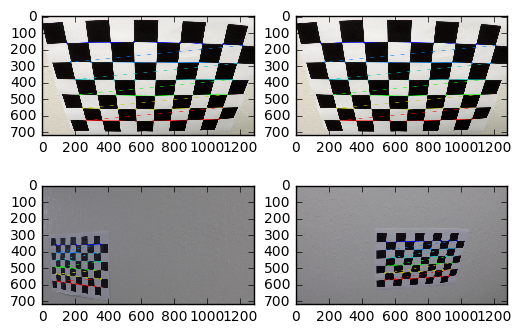

In [4]:
"""
Four random images before undistortion, with corners drawn
"""
for a in range(1,5):
    i = random.randint(0, len(images)-1)
    
    img_drawn = np.copy(images[i])
#     img_drawn = np.empty_like(images[i])
#     img_drawn[:] = images[i]
    
    corners = imgpoints[i]
    
    plt.subplot(2,2,a)
    img_drawn = cv2.drawChessboardCorners(img_drawn, (9,6), corners, True)
    
    plt.imshow(img_drawn)

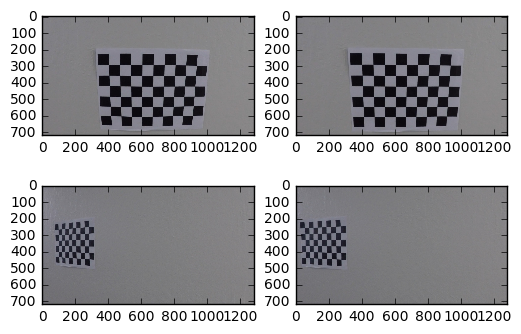

In [5]:
"""
Draw before and after undistortion for 2 images at random
"""
for a in range(1,4,2):
    i = random.randint(0, len(images)-1)
    img = images[i]
    
    plt.subplot(2,2,a)
    plt.imshow(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(2,2,a+1)
    plt.imshow(dst)

### Image transformation functions

#### Gradient thresholding saturation channel

In [6]:
def sobel_sat(img):
    """
    Returns binary of pixels
    within threshold for absolute x and y sobels
    for saturation channel only
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    
    x = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=3))
    y = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=3))
    
    scaled_x = np.uint8(255*x/np.max(x))
    scaled_y = np.uint8(255*y/np.max(y))
    
    binary_output = np.zeros_like(scaled_x)
    binary_output[(scaled_x >= 20) & 
                  (scaled_x <= 255) & 
                  (scaled_y >= 20) &
                  (scaled_y <= 255)] = 1
    return binary_output

In [7]:
# img = mpimg.imread('test_images/test5.jpg')
# binary = sobel_sat(img)
# plt.subplot(2,1,1)
# plt.imshow(img)
# plt.subplot(2,1,2)
# plt.imshow(binary,cmap='gray')

#### Yellow and white thresholding

In [8]:
def yellow_mask(img):
    """
    Returns binary of pixels where yellow color is detected
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img_hsv[:,:,0]
    S = img_hsv[:,:,1]
    V = img_hsv[:,:,2]
    
    H_bin = np.zeros_like(S)
    S_bin = np.zeros_like(S)
    V_bin = np.zeros_like(S)
    yellow_bin = np.zeros_like(S)
    
    # yellow
    H_bin[(H > 0) & (H <= 50)] = 1
    S_bin[(S > 100) & (S <= 255)] = 1
    V_bin[(V > 100) & (V <= 255)] = 1

    yellow_bin[(H_bin == 1) & (S_bin == 1) & (V_bin == 1)] = 1
    
    return yellow_bin

In [9]:
def white_mask(img):
    """
    Returns binary of pixels where white color is detected
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img_hsv[:,:,0]
    S = img_hsv[:,:,1]
    V = img_hsv[:,:,2]
    
    H_bin = np.zeros_like(S)
    S_bin = np.zeros_like(S)
    V_bin = np.zeros_like(S)
    white_bin = np.zeros_like(S)
    
    # white
    H_bin[(H > 0) & (H <= 255)] = 1
    S_bin[(S > 0) & (S <= 30)] = 1
    V_bin[(V > 200) & (V <= 255)] = 1
    
    white_bin[(H_bin == 1) & (S_bin == 1) & (V_bin == 1)] = 1
    
    return white_bin

In [10]:
def white_and_yellow(img):
    """
    Returns binary of pixels where either yellow or white color is detected
    """
    white = white_mask(img)
    yellow = yellow_mask(img)
    dst = white + yellow
    return dst

In [11]:
# img = mpimg.imread('test_images/test3.jpg')
# binary = white_and_yellow(img)
# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.subplot(1,2,2)
# plt.imshow(binary,cmap='gray')


#### Combining methods to produce binary image

In [12]:
def binary_image(img):
    """
    Returns binary image by combining white/yellow and sobel of saturation thresholding
    """
    w_y_binary = white_and_yellow(img)
    sobel_sat_binary = sobel_sat(img)
    combined = np.zeros_like(sobel_sat_binary)
    combined[(w_y_binary == 1) | (sobel_sat_binary == 1)] = 1
    return combined

#### Perspective transform

In [13]:
def transform_perspective(img):
    """
    Returns bird's eye view of image
    Based on some trial and error for various source and destination points
    """
    rows = img.shape[0]
    cols = img.shape[1]
    img_size = (cols, rows)
    slope_right = 0.6738857501569366 # Obtained empirically by eyeballing points and calculating slope
    slope_left = slope_right * -1
    delta_x = 0.3

    bl = (cols*0.15,rows)
    tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)
    br = (cols*0.88,rows)
    tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

    src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
    dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped,Minv

In [14]:
def inverse_transform_perspective(img,Minv):
    """
    Wrapper that performs perspective transform to unwarp image
    """
    rows = img.shape[0]
    cols = img.shape[1]
    img_size = (cols, rows)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

#### Masking to obtain region of interest

In [15]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Line finding functions

In [16]:
def largest_column(img):
    """
    Sums image columns and returns the index of the largest column
    """
    histogram = np.sum(img, axis=0)
    index = np.argmax(histogram)
    return index

In [17]:
# def region_of_interest2(img, vertices):
#     """
#     Applies an image mask.
    
#     Only keeps the region of the image defined by the polygon
#     formed from `vertices`. The rest of the image is set to black.
#     """
#     #defining a blank mask to start with
#     mask = np.zeros_like(img)   
    
#     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
#     if len(img.shape) > 2:
#         channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
#         ignore_mask_color = (255,) * channel_count
#     else:
#         ignore_mask_color = 255
        
#     #filling pixels inside the polygon defined by "vertices" with the fill color    
#     cv2.fillPoly(mask, vertices, ignore_mask_color)
    
#     #returning the image only where mask pixels are nonzero
#     masked_image = cv2.bitwise_and(img, mask)
#     return masked_image

In [18]:
def find_line_points(img,vert_initial=None):
    """
    Returns lane line points in a binary image
    with moving window from bottom (minus 75 pixels for hood),
    return masked image
    
    If no initial mask vertices are provided, consider entire image region of interest
    For each vertical step up through image:
        Get line location
        Update line mask
        Step up creating a new ROI near the line location
    """

    rows, cols = img.shape[0], img.shape[1]
    line_mask = np.zeros_like(img)
    keep_h = 0.1*rows
    keep_w = 0.05*cols
    roi_h = 0.1*cols
    roi_w = 0.1*cols
    step = 0.1*rows
    
    # set initial ROI
    if(vert_initial == None):
        vert_initial = np.array([[(0,rows),(0,0),(cols,0),(cols,rows)]], dtype=np.int32)
    roi = region_of_interest(img,vert_initial)
    line_loc = 0
    
    # loop through
    for bottom in range(rows-75, 0, int(-1*step)):
        line_loc_candidate = largest_column(roi)
        if(line_loc_candidate != 0):
            line_loc = line_loc_candidate
        vert_keep = np.array([[(line_loc-keep_w/2,bottom),
                          (line_loc-keep_w/2,bottom-keep_h),
                          (line_loc+keep_w/2,bottom-keep_h),
                          (line_loc+keep_w/2,bottom)]], dtype=np.int32)
        line_window = region_of_interest(np.ones_like(img),vert_keep)
        line_mask[line_window == 1] = 1
        vert_roi = np.array([[(line_loc-roi_w/2,bottom),
                          (line_loc-roi_w/2,bottom-roi_h),
                          (line_loc+roi_w/2,bottom-roi_h),
                          (line_loc+roi_w/2,bottom)]], dtype=np.int32) 
        roi = region_of_interest(img,vert_roi)

    dst = line_mask*img
    return dst

In [19]:
def find_both_lines_points(img):
    """
    Returns image with both left and right line points
    """
    rows, cols = img.shape[0], img.shape[1]
    vert_left = np.array([[(0,rows),(0,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    vert_right = np.array([[(cols,rows),(cols,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    dst_l = find_line_points(img,vert_initial=vert_left)
    dst_r = find_line_points(img,vert_initial=vert_right)
    dst = dst_l+dst_r
    return dst

### Line fitting

In [20]:
def fit_line(img):
    """
    Return polynomial fit coefficients and x/y values
    """
    points = np.nonzero(img)
    if(points[0].size == 0):
        return None,None,None
    yvals, xvals = points[0], points[1]

    fit = np.polyfit(yvals, xvals, 2)

    fity = np.arange(img.shape[0])
    fitx = fit[0]*fity**2 + fit[1]*fity + fit[2]
    
    return fit,fitx,fity

In [21]:
def get_lines(img):
    """
    Gets polynomial fits for both lines and returns in a dictionary
    """
    rows, cols = img.shape[0], img.shape[1]
    
    vert_left = np.array([[(0,rows),(0,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    vert_right = np.array([[(cols,rows),(cols,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    
    img_left = region_of_interest(img,vert_left)
    img_right = region_of_interest(img,vert_right)

    fit_left,fitx_left,fity_left = fit_line(img_left)
    fit_right,fitx_right,fity_right = fit_line(img_right)
    
    lines_dict = {'fit_left':fit_left,
                 'fitx_left':fitx_left,
                 'fity_left':fity_left,
                 'fit_right':fit_right,
                 'fitx_right':fitx_right,
                 'fity_right':fity_right}
    
    return(lines_dict)

### Measure curvature

In [22]:
def measure_curvature(fit,fitx,fity):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)
    y_eval = np.max(fity)
        
    curve_rad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                             /np.absolute(2*fit_cr[0])
    
    return curve_rad

### Adding lane, curvature, position to the image

In [ ]:
# def plot_fit_lines(both_lines_points,left_line,right_line):
#     lines = np.zeros_like(both_lines_points).astype(np.uint8)
#     lines[] = 1

In [92]:
def draw_lane_and_unwarp(img,Minv,left_line,right_line):
    
    # can just replace this with color_warp like img...
    warp_zero = np.zeros_like(img[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    fit_left = left_line.fit
    fitx_left = left_line.fitx
    fity_left = left_line.fity
    fit_right = right_line.fit
    fitx_right = right_line.fitx
    fity_right = right_line.fity
    # continue from here using left and right lines
    
    if(fit_left != None and fit_right != None):

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([fitx_left, fity_left]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx_right, fity_right])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank img
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original img space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original img
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [93]:
# def measure_curvature2(fit,fitx,fity):
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
#     fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)
#     y_eval = np.max(fity)
        
#     curve_rad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
#                              /np.absolute(2*fit_cr[0])
    
#     return curve_rad

In [94]:
def draw_curvature(img,left_line,right_line):
    dst = np.copy(img)
    left_fit = left_line.fit
    left_fitx = left_line.fitx
    left_fity = left_line.fity
    right_fit = right_line.fit
    right_fitx = right_line.fitx
    right_fity = right_line.fity
    
    if(left_fit != None):
        left_curve_rad = measure_curvature(left_fit,left_fitx,left_fity)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Left curve rad (m) = {0}'.format(left_curve_rad)
        cv2.putText(dst,text,(10,50), font, 1,(255,0,0),4,cv2.LINE_AA)
    if(right_fit != None):
        y_eval = np.max(right_line.fity)
        right_curve_rad = measure_curvature(right_fit,right_fitx,right_fity)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Right curve rad (m) = {0}'.format(right_curve_rad)
        cv2.putText(dst,text,(10,100), font, 1,(255,255,0),4,cv2.LINE_AA)
    return dst

In [95]:
def draw_position(img,left_line,right_line):
    xm = 3.7
    rows, cols = img.shape[0], img.shape[1]
    dst = np.copy(img)
    center = cols/2
    y_eval = rows - 1
    
    left_fit = left_line.fit
    left_fitx = left_line.fitx
    right_fit = right_line.fit
    right_fitx = right_line.fitx
    
    if(left_fit != None and right_fit != None):
        bottom_left = left_fitx[y_eval] #30
        bottom_right = right_fitx[y_eval] #100 center = 40
        span = bottom_right-bottom_left #70
        position = xm*(center - bottom_left)/(bottom_right - bottom_left) - xm/2
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Offset from lane center (m) = {0}'.format(position)
        cv2.putText(dst,text,(10,150), font, 1,(0,0,255),4,cv2.LINE_AA)
    return dst

### Image pipeline

In [114]:
def image_pipeline(img):
    """
    Process image and returns the final image
    With 
    intermediate representations, and other useful stuff
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    
    transformed,Minv = transform_perspective(binary)
    both_lines_points = find_both_lines_points(transformed)
    
    position = None
    return undist,binary,transformed,both_lines_points,Minv

In [115]:
def both_lines_points_and_Minv(img):
    """
    Wrapper on pipeline that returns just lines and Minv
    """
    undist,binary,transformed,both_lines_points,Minv = \
        image_pipeline(img)
    
    return both_lines_points,Minv

### Line class

In [99]:
class Line():
    def __init__(self):
        self.fit = None
        self.fitx = None
        self.fity = None
        self.misses = 0
    
    def __sanity_check(self,fit):
        if(abs(self.fit[0] - fit[0]) > 0.05):
            return False
        else:
            return True
    
    def update(self,fit,fitx,fity):
        """
        If consecutive misses >= threshold:
            set self.fit to none
            reset consecutive misses

        If self.fit is none
            If a line is found:
                update the fit 
            If a line is not found
                pass

        If self.fit exists
            If a line is found:
                perform a sanity check
                If it passes:
                    update the fit with a weighted average
                If it fails:
                    keep existing fit
                    increment consecutive_failures
            If a line is not found:
                keep existing fit
                increment consecutive_failures
        """
        if(self.misses >= 1):
            self.fit, self.fitx, self.fity = None, None, None
            self.misses = 0
        if(self.fit == None):
            if(fit != None):
                self.fit, self.fitx, self.fity = fit, fitx, fity
            else:
                pass
        else:
            if(fit != None):
                sanity = self.__sanity_check(fit)
                if(sanity == True):
                    self.fit = self.fit
#                     self.fitx = fitx
#                     self.fitx = 0.9 * self.fitx + 0.1 * fitx
                    self.fitx = fit[0]*fity**2 + fit[1]*fity + fit[2]
                    self.fity = fity
                else:
                    self.misses += 1
            else:
                self.misses += 1

### Process images and movies

#### Function called to process each frame

In [131]:
def process_movie_frame(img):
    """
    Process an image and take advantage of past data in the line class
    """
#     both_lines_points,Minv = both_lines_points_and_Minv(img)
    undist,binary,transformed,both_lines_points,Minv = image_pipeline(img)
    lines_dict = get_lines(both_lines_points)
    left_line.update(lines_dict['fit_left'],lines_dict['fitx_left'],lines_dict['fity_left'])
    right_line.update(lines_dict['fit_right'],lines_dict['fitx_right'],lines_dict['fity_right'])
    
    lane = draw_lane_and_unwarp(img,Minv,left_line,right_line)
    curvature = draw_curvature(lane,left_line,right_line)
    position = draw_position(curvature,left_line,right_line)
    final = position
    
    return final,both_lines_points,transformed,binary,undist

In [132]:
def process_wrapper(img):
    final,both_lines_points,transformed,binary,undist = process_movie_frame(img)
    return final

#### Test on a sample image

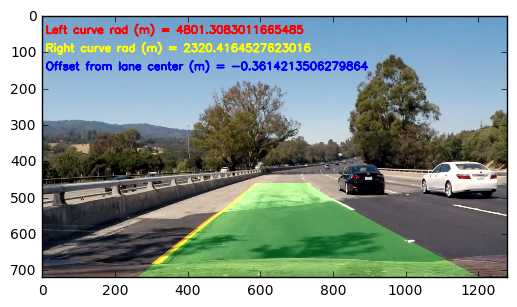

In [121]:
left_line = Line()
right_line = Line()
img = mpimg.imread('test_images/test4.jpg')
result = process_wrapper(img)
plt.imshow(result)

#### Test on a movie and save the output

In [122]:
left_line = Line()
right_line = Line()
output_name = 'output_images/short_3.mp4'
clip0 = VideoFileClip('short_video.mp4')
white_clip = clip0.fl_image(process_wrapper)
%time white_clip.write_videofile(output_name, audio=False, codec='mpeg4')

[MoviePy] >>>> Building video output_images/short_3.mp4
[MoviePy] Writing video output_images/short_3.mp4


100%|█████████▉| 214/215 [00:48<00:00,  4.50it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/short_3.mp4 

CPU times: user 1min 33s, sys: 7.88 s, total: 1min 41s
Wall time: 48.9 s


### Scratchpad

#### Figuring out src and dst points for perspective transform

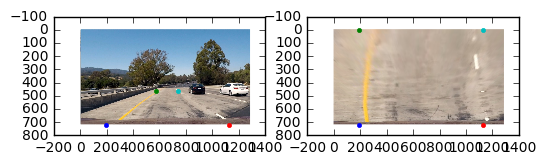

In [78]:
img = mpimg.imread('test_images/test1.jpg')
rows = img.shape[0]
cols = img.shape[1]
img_size = (cols, rows)

slope_right = 0.6738857501569366
slope_left = slope_right * -1

delta_x = 0.3 #.34

bl = (cols*0.15,rows)
tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)

br = (cols*0.88,rows)
tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

plt.subplot(2,2,1)
plt.imshow(img)
plt.plot(bl[0],bl[1],'.')
plt.plot(tl[0],tl[1],'.')
plt.plot(br[0],br[1],'.')
plt.plot(tr[0],tr[1],'.')

src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplot(2,2,2)
plt.imshow(warped)
plt.plot(bl[0],bl[1],'.')
plt.plot(bl[0],0,'.')
plt.plot(br[0],br[1],'.')
plt.plot(br[0],0,'.')

#### Viewing intermediate representations in the pipeline

In [140]:
left_line = Line()
right_line = Line()

img = mpimg.imread('test_images/test1.jpg')

final,both_lines_points,transformed,binary,undist = \
    process_movie_frame(img)

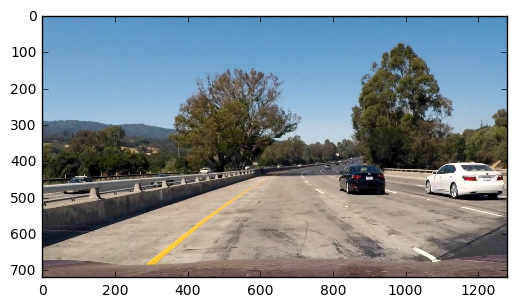

In [141]:
plt.imshow(img)

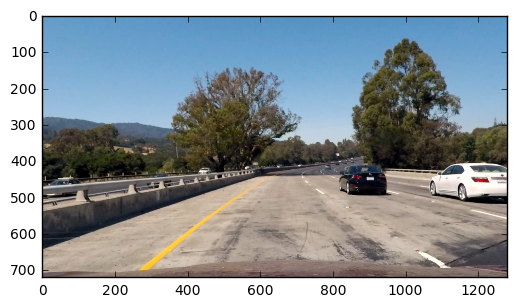

In [142]:
plt.imshow(undist)

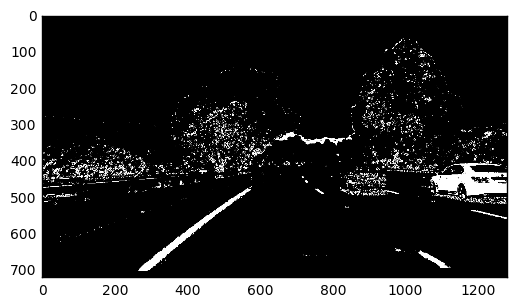

In [143]:
plt.imshow(binary,cmap='gray')

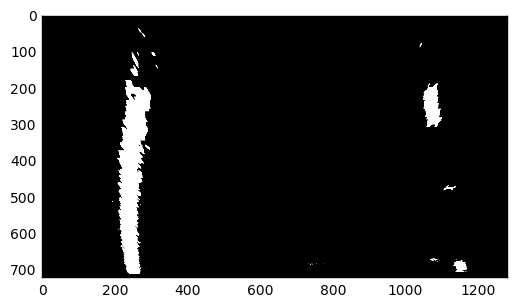

In [144]:
plt.imshow(transformed,cmap='gray')

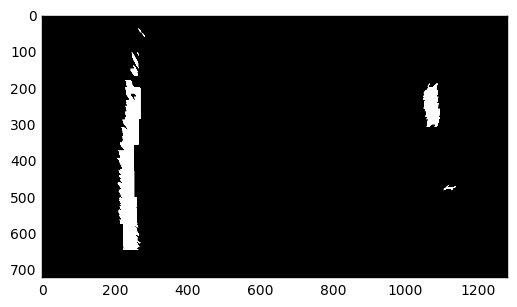

In [150]:
plt.imshow(both_lines_points,cmap='gray')

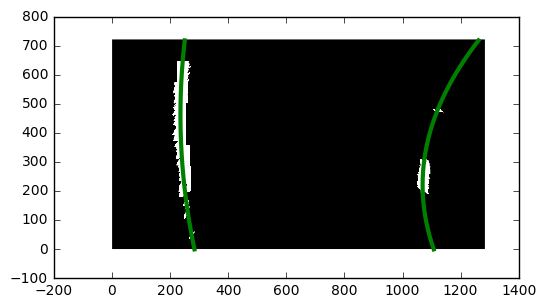

In [151]:
plt.imshow(both_lines_points,cmap='gray')
plt.plot(left_line.fitx, left_line.fity, color='green', linewidth=3)
plt.plot(right_line.fitx, right_line.fity, color='green', linewidth=3)
plt.gca().invert_yaxis()

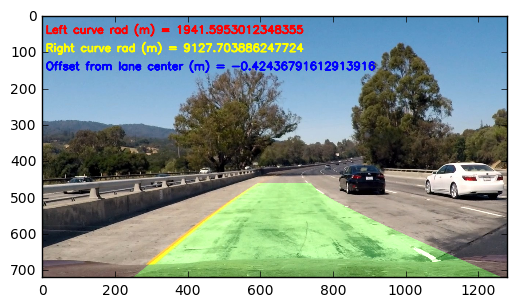

In [146]:
plt.imshow(final)